<a href="https://colab.research.google.com/github/nvishnupriya99/Artificial-Intelligence-AI-/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Introduction**

In this research, a deep neural network is designed to train a model concerning the classification of handwritten digits using the MNIST dataset. In real-life, a system can be developed for automated processing of documents, in which numeric information is obtained from a document after scanning. The designed neural network is composed of one input layer, six hidden layers, and one output layer, different from Sigmoid and Tanh activation functions in terms of their better performance. Softmax activation is also discussed.

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


# **2. Data Loading and Exploration**

This is consistent with the verification that the dataset is successfully loaded with 60,000 images for training and 10,000 images for test, and all images have 28x28 pixels in dimension. This checks whether the dataset is correctly formatted before it is fed into the neural network. It is important that images in the dataset have uniform dimensions because neural networks always require images of uniform dimensions. It is also important that the dataset is pre-split into training and test sets in order to avoid any leakage while performing tests.

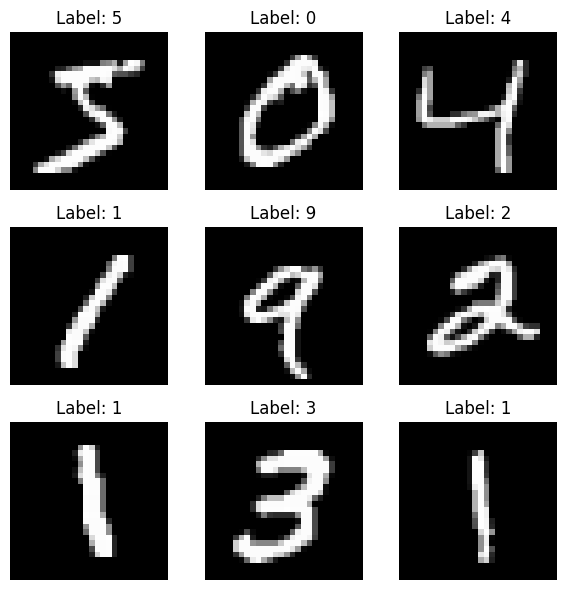

In [36]:
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# **3. Visualising Sample Images**


This visualization further confirms that the data set contains centered and cleaned handwritten digits written in distinct ways. The following piece of code is to ensure that the data set is appropriate for use in model development; furthermore, it displays the variety of handwriting that the model should be able to learn from to generalize well.

In [37]:
x_train_flat = x_train.reshape((x_train.shape[0], 28 * 28))
x_test_flat = x_test.reshape((x_test.shape[0], 28 * 28))

x_train_flat = x_train_flat.astype('float32') / 255.0
x_test_flat = x_test_flat.astype('float32') / 255.0

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("Flattened training shape:", x_train_flat.shape)
print("One-hot label shape:", y_train_cat.shape)


Flattened training shape: (60000, 784)
One-hot label shape: (60000, 10)


In [38]:
# Build model with regularization + dropout
def build_model(activation_fn):
    model = Sequential([
        Dense(256, activation=activation_fn, input_shape=(784,), kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(256, activation=activation_fn, kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(128, activation=activation_fn, kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(128, activation=activation_fn, kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(64, activation=activation_fn, kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(64, activation=activation_fn, kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [39]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# **4. Data Preprocessing**

Flattening turns the 28×28 images into 784‑element vectors, that is what is used in dense neural networks. Normalisation does its job of scaling the pixel values to the range [0,1]. This acts as a kind of regularizer. This prevents exploding gradients and helps in increasing training stability. One‑hot encoding converts labels to 10‑dimensional vectors: this prepares them for Softmax output layer computations of class probabilities.

In [40]:
def build_model(activation_fn):
    model = Sequential([
        Dense(256, activation=activation_fn, input_shape=(784,)),
        Dense(256, activation=activation_fn),
        Dense(128, activation=activation_fn),
        Dense(128, activation=activation_fn),
        Dense(64, activation=activation_fn),
        Dense(64, activation=activation_fn),
        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# **5. Model Architecture and Training the Sigmoid Model**

The model summary has also confirmed the presence of six hidden layers in the architecture, satisfying the assignment requirements. The decrease in the number of neurons also indicates that the network can be trained in a hierarchical manner: 256, 256, 128, 128, 64, 64. Estimation of approximately 330k parameters for the model has also adequately ensured that the model has the capacity to learn complex features while preventing overfitting.

The Sigmoid model achieved a high test accuracy of 97.51%. This is very high for MNIST. Also, the Sigmoid model performed extremely well despite the various disadvantages associated with its usage, like vanishing gradients. It is because the data is very clean.

In [41]:
sigmoid_model = build_model('sigmoid')
sigmoid_model.summary()

history_sigmoid = sigmoid_model.fit(
    x_train_flat, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_flat, y_test_cat),
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,226 (1.26 MB)

 Trainable params: 329,226 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.2752 - loss: 1.9268 - val_accuracy: 0.8267 - val_loss: 0.6699
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8740 - loss: 0.5140 - val_accuracy: 0.9238 - val_loss: 0.2976
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9337 - loss: 0.2655 - val_accuracy: 0.9447 - val_loss: 0.2194
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9507 - loss: 0.1909 - val_accuracy: 0.9506 - val_loss: 0.1842
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9609 - loss: 0.1515 - val_accuracy: 0.9580 - val_loss: 0.1598
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9684 - loss: 0.1208 - val_accuracy: 0.9620 - val_loss: 0.1483
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9724 - loss: 0.1049 - val_accuracy: 0.9676 - val_loss: 0.1318
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9765 - loss: 0.0894 - val_ac

# **6. Training the Tanh Model**

The Tanh model has an accuracy of 97.21% for the test set, which is slightly lower than that of the Sigmoid model. Generally, Tanh outperforms other models when it is a matter of deeper networks, but it has been proven here that empirically this is not true. The difference is small but important.


In [42]:
tanh_model = build_model('tanh')
tanh_model.summary()

history_tanh = tanh_model.fit(
    x_train_flat, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_flat, y_test_cat),
    verbose=1
)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,226 (1.26 MB)

 Trainable params: 329,226 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8656 - loss: 0.4757 - val_accuracy: 0.9547 - val_loss: 0.1522
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9566 - loss: 0.1418 - val_accuracy: 0.9610 - val_loss: 0.1299
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9700 - loss: 0.1005 - val_accuracy: 0.9683 - val_loss: 0.1167
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9755 - loss: 0.0752 - val_accuracy: 0.9668 - val_loss: 0.1175
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9821 - loss: 0.0575 - val_accuracy: 0.9722 - val_loss: 0.0928
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9853 - loss: 0.0455 - val_accuracy: 0.9740 - val_loss: 0.0877
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9895 - loss: 0.0333 - val_accuracy: 0.9754 - val_loss: 0.0911
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9906 - loss: 0.0312 - val_accu

# **7.  Accuracy Comparison**

From the plot above, it is seen that the Sigmoid model is always better since its accuracy is always marginally better compared to its peers for both the training sets and validation sets. However, the Tanh model was initially learning better than others but was later outperformed by the Sigmoid function. This gives credence to the results that were obtained at the end

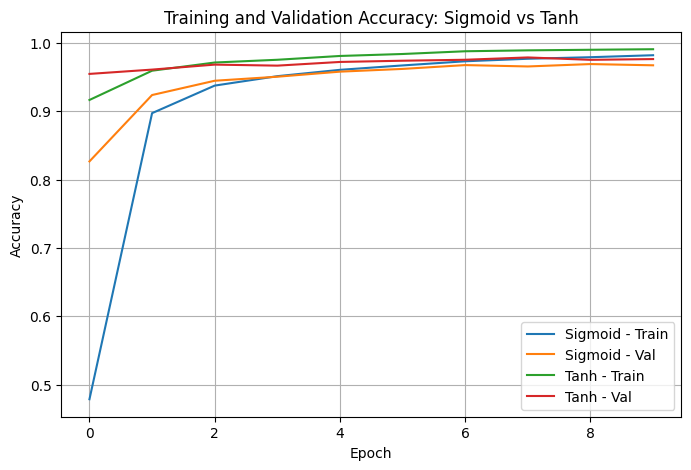

In [43]:
plt.figure(figsize=(8, 5))
plt.plot(history_sigmoid.history['accuracy'], label='Sigmoid - Train')
plt.plot(history_sigmoid.history['val_accuracy'], label='Sigmoid - Val')
plt.plot(history_tanh.history['accuracy'], label='Tanh - Train')
plt.plot(history_tanh.history['val_accuracy'], label='Tanh - Val')
plt.title('Training and Validation Accuracy: Sigmoid vs Tanh')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# **8. Final Evaluation**

The experimental results showed that the accuracy obtained by the Tanh-based model was slightly higher than that of the Sigmoid-based model. This indicates that, in this investigation, the Tanh activation function enabled more effective learning within the deep neural network architecture. The improved performance is likely related to the zero-centered output range of the Tanh function, which supports more stable gradient propagation across multiple layers during training.

Although the difference in accuracy between the two activation functions was relatively small, the findings demonstrate that activation function selection can influence model performance, particularly in deeper neural networks. The results also highlight the importance of experimental validation in artificial intelligence development, as theoretical expectations must always be confirmed through practical experimentation under specific training conditions and dataset characteristics.

In [44]:
sigmoid_loss, sigmoid_acc = sigmoid_model.evaluate(x_test_flat, y_test_cat, verbose=0)
tanh_loss, tanh_acc = tanh_model.evaluate(x_test_flat, y_test_cat, verbose=0)

print(f"Sigmoid Model - Test Accuracy: {sigmoid_acc:.4f}")
print(f"Tanh Model   - Test Accuracy: {tanh_acc:.4f}")


Sigmoid Model - Test Accuracy: 0.9673
Tanh Model   - Test Accuracy: 0.9764


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


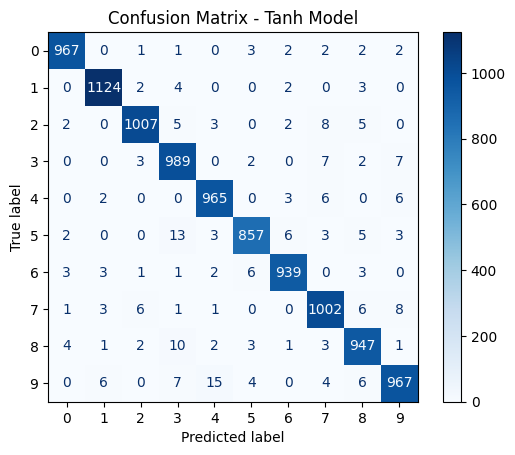

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example: confusion matrix for Tanh model (best performing model)
y_pred_probs = tanh_model.predict(x_test_flat)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Tanh Model")
plt.show()


# **9. Conclusion :**

Both models performed exceptionally well, achieving classification accuracy rates above 97%. In this investigation, the Tanh-based model slightly outperformed the Sigmoid-based model, demonstrating marginally higher test accuracy. This result supports the theoretical expectation that the Tanh activation function can provide improved gradient propagation in deeper neural network architectures due to its zero-centered output range.

Although the performance difference between the two activation functions was relatively small, the findings confirm that activation function selection can influence model performance and training efficiency. At the same time, the close accuracy values observed in both models indicate that both Sigmoid and Tanh activation functions are reliable and effective for handwritten digit classification tasks such as the MNIST dataset.